### Example 3: Image Interpolation

### Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
from utils import DSSIM, cf, cf_g

plt.rcParams.update({'font.size': 12})

%reload_ext autoreload
%autoreload 2

## Definition of the target function/image

In [2]:
pic_folder = './pic'
pic_file = 'cameraman' # pic_file = 'baboon', 'cameraman', 'lenna', 'peppers'

src = cv2.imread(osp.join(pic_folder, pic_file + '.png'))

src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
src = src / np.max(src)

## Computation of the asymptotic constant

In [3]:
c_f = cf(src.flatten())

## Computation of the interpolants

In [4]:
# Fill distance
h = []
pixels = []

# DSSIM
dssim1 = []
dssim2 = []

# L2 error
l2_1 = []
l2_2 = []

# c_fg
g_dependent_const_1 = []
g_dependent_const_2 = []


# Run for different grid sizes
for k in range(1, 5):

    # Define the grid step size
    step = 2 ** (-k -2) / 5
    
    # Compute the number of pixels
    pixel = int(1/step)
    pixels.append(pixel)
    print('Solving the interpolation problems with %5d pixels' % (pixel ** 2))
    
    # Store the fill distance    
    h.append(np.sqrt(2) / 2 * step)
    
    # Compute the bilinear interpolant
    val = cv2.resize(cv2.resize(src, (pixel, pixel)), (512, 512), interpolation=cv2.INTER_LINEAR)
    dssim1.append(DSSIM(val.flatten(), src.flatten()))
    l2_1.append(np.linalg.norm(val.flatten() - src.flatten(), 2) ** 2  / (src.shape[0]**2))
    g_dependent_const_1.append(cf_g(val.flatten(), src.flatten()))
    
    # Compute the bicubic interpolant
    val = cv2.resize(cv2.resize(src, (pixel, pixel)), (512, 512), interpolation=cv2.INTER_CUBIC)
    dssim2.append(DSSIM(val.flatten(), src.flatten()))
    l2_2.append(np.linalg.norm(val.flatten() - src.flatten(), 2) ** 2  / (src.shape[0]**2))
    g_dependent_const_2.append(cf_g(val.flatten(), src.flatten()))

Solving the interpolation problems with  1600 pixels
Solving the interpolation problems with  6400 pixels
Solving the interpolation problems with 25600 pixels
Solving the interpolation problems with 102400 pixels


## Plot

### Cleanup

In [5]:
dssim1 = np.array(dssim1)
dssim2 = np.array(dssim2)

dssim1[np.where(dssim1<1e-16)[0]] = 1e-17
dssim2[np.where(dssim2<1e-16)[0]] = 1e-17

h = np.array(h)

g_dependent_const_1 = np.array(g_dependent_const_1)
g_dependent_const_2 = np.array(g_dependent_const_2)

l2_1 = np.array(l2_1)
l2_2 = np.array(l2_2)

### Estimation of the asymptotic rates

In [6]:
idx = np.argwhere(np.abs(dssim1) > 1e-16).ravel()
c1 = np.polyfit(np.log(h[idx]), np.log(dssim1[idx]), 1)
idx = np.argwhere(np.abs(dssim2) > 1e-16).ravel()
c2 = np.polyfit(np.log(h[idx]), np.log(dssim2[idx]), 1)

c_l2_1 = np.mean(np.array(dssim1) / (c_f * l2_1))
c_l2_2 = np.mean(np.array(dssim2) / (c_f * l2_2))

### Plot

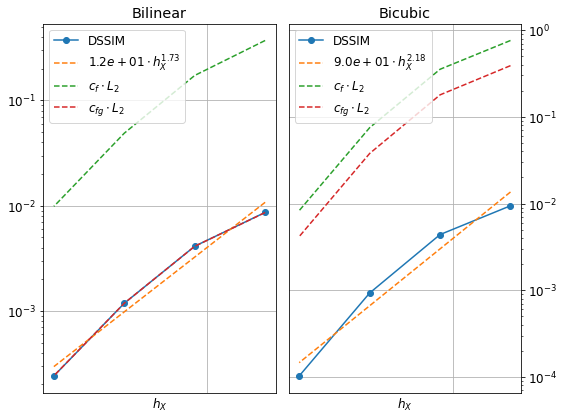

In [7]:
fig = plt.figure(figsize=(8, 6))
fig.clf()

ax = fig.add_subplot(1, 2, 1)
ax.loglog(h, dssim1, 'o-')
ax.loglog(h, np.exp(c1[1]) * h ** c1[0], '--')
ax.loglog(h, g_dependent_const_1 * l2_1, '--')
ax.loglog(h, c_l2_1 * c_f * l2_1, '--')
ax.grid(True)
ax.legend(['DSSIM', '$%1.1e \cdot h_X^{%2.2f}$' % (np.exp(c1[1]), c1[0]), 
           '$c_f \cdot L_2$', '$c_{fg} \cdot L_2$'],
           loc='upper left')
ax.set_xlabel('$h_X$')
ax.set_title('Bilinear')
ax.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 

ax = fig.add_subplot(1, 2, 2)
ax.loglog(h, dssim2, 'o-')
ax.loglog(h, np.exp(c2[1]) * h ** c2[0], '--')
ax.loglog(h, c_f * l2_2, '--')
ax.loglog(h, g_dependent_const_2 * l2_2, '--')
ax.grid(True)
ax.legend(['DSSIM', '$%1.1e \cdot h_X^{%2.2f}$' % (np.exp(c2[1]), c2[0]), 
           '$c_f \cdot L_2$', '$c_{fg} \cdot L_2$'],
          loc='upper left')
ax.set_xlabel('$h_X$')
ax.set_title('Bicubic')
ax.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')

fig.tight_layout()
fig.savefig('image_' + pic_file + '.pdf')